In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from epitools import within_p, between_p

In [67]:
country = "France"
year = 2002
election = "first_round"
aggregation = "department_id" # "department_id"

input_df_location = pd.read_csv(f"data_output/{country}/{year}_{election}_location.csv.gz", compression="gzip")
input_df = pd.read_csv(f"data_output/{country}/{year}_{election}.csv.gz")
input_df = pd.merge(input_df, input_df_location[["polling_id", aggregation]])
if country == "France":
    input_df = input_df[~input_df[aggregation].str.contains("Z")]
input_df.head()

,polling_id,candidate,value,rank,rate,department_id
0,01-1-1,BRUNO MEGRET,14,11,0.032787,01
1,01-1-1,CORINNE LEPAGE,9,13,0.021077,01
2,01-1-1,DANIEL GLUCKSTEIN,1,16,0.002342,01
3,01-1-1,FRANCOIS BAYROU,30,5,0.070258,01
4,01-1-1,JACQUES CHIRAC,66,2,0.154567,01


In [68]:
candidates = input_df.groupby("candidate").agg({"value": "sum"}).sort_values("value", ascending=False).reset_index()
candidates["cumulative"] = candidates["value"].cumsum() / candidates["value"].sum()
candidates["N_candidates"] = range(1, candidates.shape[0] + 1)

candidates["year"] = year
candidates.to_csv(f"data_robustness/{country}/cumulative_{year}.csv", index=False)
candidates.head()

,candidate,value,cumulative,N_candidates,year
0,JACQUES CHIRAC,5385936,0.194067,1,2002
1,JEAN-MARIE LE PEN,4770550,0.365961,2,2002
2,LIONEL JOSPIN,4398209,0.524438,3,2002
3,FRANCOIS BAYROU,1927929,0.593905,4,2002
4,ARLETTE LAGUILLER,1615655,0.652121,5,2002


In [62]:
output = []

for N_candidates in range(2, candidates.shape[0] + 1):
    cnd = candidates.head(N_candidates)["candidate"].unique()

    df = input_df[input_df["candidate"].isin(cnd)].copy()
    df_frag = input_df[~input_df["candidate"].isin(cnd)].copy()
    df_frag["candidate"] = "OTHER"
    df = pd.concat([df, df_frag])

    tt = df.groupby([aggregation, "polling_id", "candidate"]).agg({"value": "sum"})
    tt["rate"] = tt.groupby(level=[0, 1], group_keys=False).apply(lambda x: x/x.sum())
    tt = tt.reset_index()

    for idx, data in tt.groupby(aggregation):
        within = within_p(data)["value"].sum()
        between = between_p(data)["value"].sum()
        output.append({
            aggregation: idx,
            "within": within,
            "between": between,
            "value": within + between,
            "N_candidates": N_candidates
        })

output_df = pd.DataFrame(output)
output_df["year"] = year
output_df.to_csv(f"data_robustness/{country}/candidates_{year}.csv", index=False)
output_df

,department_id,within,between,value,N_candidates,year
0,01,0.063867,0.831264,0.895131,2,2012
1,02,0.073137,0.815859,0.888997,2,2012
2,03,0.068513,0.837911,0.906424,2,2012
3,04,0.057055,0.812770,0.869826,2,2012
4,05,0.057659,0.817767,0.875426,2,2012
...,...,...,...,...,...,...
868,91,0.032002,0.867904,0.899906,10,2012
869,92,0.035380,0.850627,0.886007,10,2012
870,93,0.029891,0.858659,0.888550,10,2012
871,94,0.031372,0.860199,0.891571,10,2012


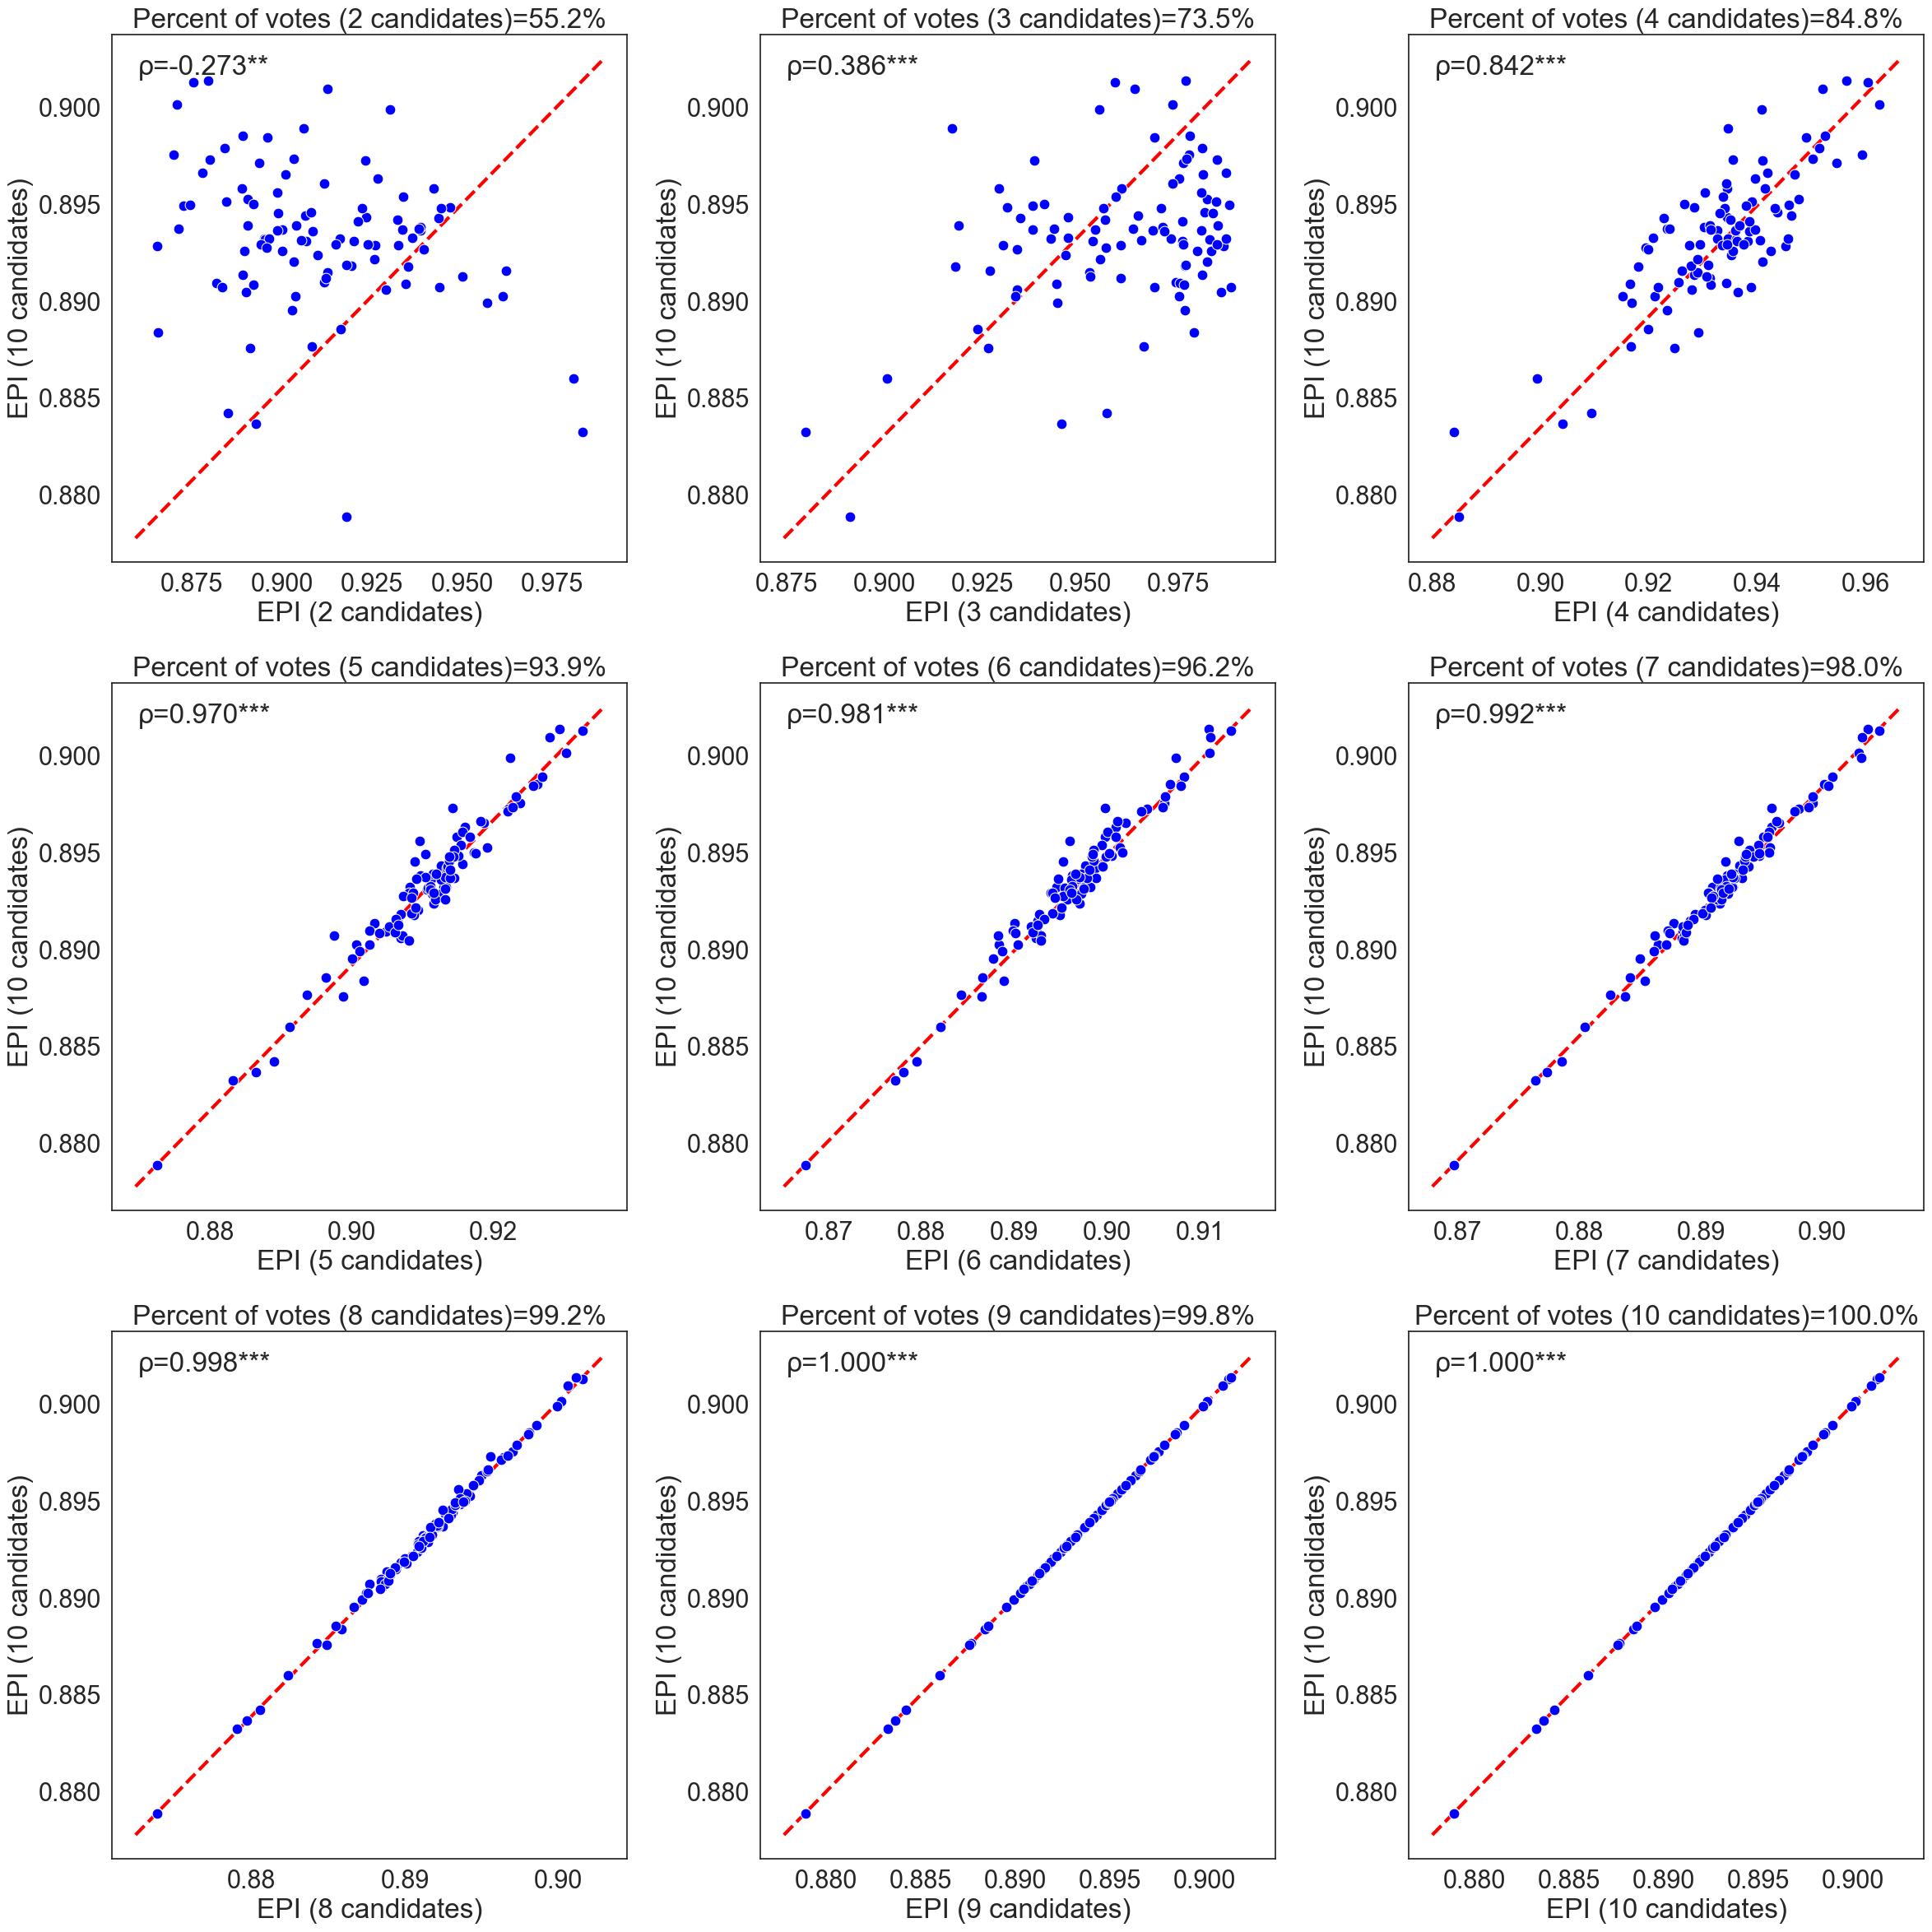

In [63]:
sns.set(font_scale=2, style="white")

if country == "France":
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
else:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

threshold = 10 + 1
if country == "Chile":
    threshold = 7 + 1

for N_candidates in range(2, min(candidates.shape[0] + 1, threshold)): #10 + 1

    idx = N_candidates - 2
    ax = axs[int(idx/3), idx%3]

    data = pd.merge(
        output_df[output_df["N_candidates"] == N_candidates],
        output_df[output_df["N_candidates"] == candidates.shape[0]],
        on=aggregation
    )

    sns.scatterplot(
        x="value_x",
        y="value_y",
        data=data,
        # linewidth=0.25,
        s=85,
        zorder=2,
        color="blue",
        ax=ax
    )

    corr, pvalue = pearsonr(data["value_x"], data["value_y"])
    def corrfunc(corr, pvalue, ax):
        ax = plt.gca()
        note = ""
        if pvalue < 0.001:
            note = "***"
        elif pvalue < 0.05:
            note = "**"
        elif pvalue < 0.1:
            note = "*"

        return "ρ={:.3f}{}".format(corr, note)

    val = corrfunc(corr, pvalue, ax)
    ax.annotate(val, xy=(.05, .925), xycoords=ax.transAxes)

    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), zorder=1, color="red", lw=3, ls="--")

    ax.set_xlabel(f"EPI ({N_candidates} candidates)")
    ax.set_ylabel(f"EPI ({candidates.shape[0]} candidates)")
    ax.set_title(f"Percent of votes ({N_candidates} candidates)={round(candidates.iloc[idx + 1].cumulative * 100, 1)}%")

fig.tight_layout()

fig.savefig(f"Figures_Appendix/Rb_multicandidate_{country}_{year}.pdf")
